In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import folium
import json
from folium import plugins

# Find Max Latitude and Longitude City Boundaries

In [4]:
boundaries_df = pd.read_csv("City_Boundary_layer.csv")
data = boundaries_df['the_geom'].array[0].split('((')  # split the data on the double opening brackets so the first entry becomes 'POLYGON '
data = data[1].strip('))')  # data becomes the data excluding 'POLYGON ' and the double closing brackets at the end are removed
data = data.split(',')  # data gets split on commas
for i in range(len(data)):
    data[i] = data[i].split(' ')
    
boundaries_df['longitude'] = ''
boundaries_df['latitude'] = ''
boundaries_df = boundaries_df.append({'longitude': data[0][0],'latitude': data[0][1]},ignore_index=True)
for i in range(1,len(data)):
    boundaries_df = boundaries_df.append({'longitude': data[i][1],'latitude': data[i][2]},ignore_index=True)
boundaries_df = boundaries_df[1:]  # get rid of the empty first row
boundaries_df = boundaries_df[['latitude','longitude']]  # get rid of extraneous columns
east_bound = float(boundaries_df['longitude'].min())   # east boundary is the minimum longitude
west_bound = float(boundaries_df['longitude'].max())   # west boundary is the maximum longitude
north_bound = float(boundaries_df['latitude'].max())   # north boundary is the maximum latitude
south_bound = float(boundaries_df['latitude'].min())   # south boundary is the minimum latitude


In [5]:
# print(boundaries_df)
print("West bound: ",west_bound)
print("East bound: ",east_bound)
print("North bound: ",north_bound)
print("South bound: ",south_bound)

West bound:  -114.315796
East bound:  -113.859905
North bound:  51.212425
South bound:  50.842822


# Find lat and long bins for grid system according to max and min lat/longs

In [6]:
boundaries_df.latitude = boundaries_df.latitude.astype(float)
boundaries_df.longitude = boundaries_df.longitude.astype(float)

boundaries_df['latitude_bins'] = pd.cut(boundaries_df['latitude'],bins=10,precision=6)#,labels=[10,9,8,7,6,5,4,3,2,1]
boundaries_df['longitude_bins'] = pd.cut(boundaries_df['longitude'],bins=10,precision=6)#,labels=[1,2,3,4,5,6,7,8,9,10]

# Create Bins Lists For The Master Grid DataFrame

In [7]:
latitude_bins_list = boundaries_df['latitude_bins'].unique()   # find unique latitude bins
longitude_bins_list = boundaries_df['longitude_bins'].unique()  # find unique longitude bins
longitude_bins_list = longitude_bins_list.sort_values()  # sort longitude bins so the grid can be built in a loop


# Create Master Grid DataFrame

In [8]:
grid_df = pd.DataFrame(columns = ['lat_high','lat_low','long_high','long_low'])
grid_df
for i in range(len(latitude_bins_list)):
    for j in range(len(longitude_bins_list)):
        grid_df = grid_df.append({'lat_high':float(latitude_bins_list[i].right),'lat_low':float(latitude_bins_list[i].left),
                                  'long_high':float(longitude_bins_list[j].left),'long_low':float(longitude_bins_list[j].right)},
                                 ignore_index=True)
grid_df.index = range(1,len(grid_df)+1)

# Find the amount of traffic incidents inside each grid

In [12]:
traffic_accidents_df = pd.read_csv("Traffic_Incidents.csv")

traffic_accidents_df.dropna(axis=1, how='all')    # remove the empty columns with all NaN values
traffic_accidents_df = traffic_accidents_df[~traffic_accidents_df.START_DT.str.contains("/2016 ")]     # remove all non 2018 data
traffic_accidents_df = traffic_accidents_df[~traffic_accidents_df.START_DT.str.contains("/2017 ")]
traffic_accidents_df = traffic_accidents_df[~traffic_accidents_df.START_DT.str.contains("/2019 ")]
traffic_accidents_df = traffic_accidents_df[~traffic_accidents_df.START_DT.str.contains("/2020 ")]
traffic_accidents_df = traffic_accidents_df.drop(['MODIFIED_DT','location','Count','id'],axis=1)

grid_incidents_df = grid_df
incident_count_df = pd.DataFrame(columns=['incident_count'])

for i in range(len(grid_df)):   # iterate through grid_df and traffic_accidents dataframes to find the amount of incidents in each grid
    count = 0
    for j in range(len(traffic_accidents_df)):
        if (grid_df.iloc[i,1] <= traffic_accidents_df.iloc[j,4] < grid_df.iloc[i,0]) and \
        (grid_df.iloc[i,2] <= traffic_accidents_df.iloc[j,3] < grid_df.iloc[i,3]):
            count+=1
    incident_count_df = incident_count_df.append({'incident_count':count},ignore_index=True)

incident_count_df.index = range(1,len(incident_count_df)+1)
grid_incidents_df = grid_incidents_df.join(incident_count_df)
pd.set_option("display.max_rows", None)   

# Find the amount of cameras inside each grid

In [8]:
grid_incidents_cameras_df = grid_incidents_df
cameras_df = pd.read_csv("Traffic_Camera_Locations.csv")
cameras_df = cameras_df.drop(['Camera URL','Camera Location','Quadrant'],axis=1)

camera_count_df = pd.DataFrame(columns=['camera_count'])

for i in range(len(grid_df)):   # iterate through grid_df and cameras_df dataframes to find the amount of incidents in each grid
    count = 0
    for j in range(len(cameras_df)):
        if (grid_df.iloc[i,1] <= cameras_df.iloc[j,1] < grid_df.iloc[i,0]) and \
        (grid_df.iloc[i,2] <= cameras_df.iloc[j,0] < grid_df.iloc[i,3]):
            count+=1
    camera_count_df = camera_count_df.append({'camera_count':count},ignore_index=True)

camera_count_df.index = range(1,len(camera_count_df)+1)
grid_incidents_cameras_df = grid_incidents_cameras_df.join(camera_count_df)
pd.set_option("display.max_rows", None)            


# Find Average Speed Limit Inside Each Grid

In [9]:
grid_incidents_cameras_speeds_df = grid_incidents_cameras_df

speed_limit_df = pd.read_csv("Speed_Limits.csv")

# cleaning the speed_limit data
speed_limit_df['multiline'] = speed_limit_df['multiline'].str.replace(r'[MULTILINESTRING]','').str.replace(r'\(','').str.replace(r'\)','').str.replace(r'\)','').str.replace("−", "-").str.strip()
speed_limit_df.dropna(subset = ["SPEED"], inplace=True)

# taking the multilinestring coordinates and creating a latitude and longitude column in the data frame. We will assume that the first point is an accurate representation of the location for the line segments
latitude = []
longitude = []
for temp in speed_limit_df.multiline:
    temp = temp.split(',')
    for i in temp:
        i = i.split()
        latitude.append(float(i[1]))
        longitude.append(float(i[0]))
        break
    
speed_limit_df['latitude'] = latitude
speed_limit_df['longitude'] = longitude
speed_limit_df = speed_limit_df.drop(['BOUND','CREATED_DT','DISTANCE','multiline'], axis=1)
speed_limit_df = speed_limit_df.sort_values('SPEED',ascending=False)

speed_average_df = pd.DataFrame(columns=['average_speed_limit'])

for i in range(len(grid_df)): # iterate through grid_df and speed_limit_df dataframes to find the amount of incidents in each grid
    count = 0
    sum_speed = 0
    average = 0
    for j in range(len(speed_limit_df)):
        if (grid_df.iloc[i,1] <= speed_limit_df.iloc[j,2] < grid_df.iloc[i,0]) and \
        (grid_df.iloc[i,2] <= speed_limit_df.iloc[j,3] < grid_df.iloc[i,3]):
            count+=1
            sum_speed+=speed_limit_df.iloc[j,0]
        if(count > 0):
            average=sum_speed/count
    speed_average_df = speed_average_df.append({'average_speed_limit':average},ignore_index=True)

speed_average_df.index = range(1,len(speed_average_df)+1)
grid_incidents_cameras_speeds_df = grid_incidents_cameras_speeds_df.join(speed_average_df)
pd.set_option("display.max_rows", None)            


# Find Average Traffic Volume Inside Each Grid

In [10]:
grid_incidents_cameras_speeds_volumes_df = grid_incidents_cameras_speeds_df

traffic_volume_df = pd.read_csv("Traffic_Volumes_for_2018.csv")

# cleaning the traffic volume data
traffic_volume_df['multilinestring'] = traffic_volume_df['multilinestring'].str.replace(r'[MULTILINESTRING]','').str.replace(r'\(','').str.replace(r'\)','').str.replace(r'\)','').str.replace("−", "-").str.strip()
traffic_volume_df.dropna(subset = ["VOLUME"], inplace=True)

# taking the multilinestring coordinates and creating a latitude and longitude column in the data frame. We will assume that the first point is an accurate representation of the location for the line segments
latitude = []
longitude = []
for temp in traffic_volume_df.multilinestring:
    temp = temp.split(',')
    for i in temp:
        i = i.split()
        latitude.append(float(i[1]))
        longitude.append(float(i[0]))
        break
    
traffic_volume_df['latitude'] = latitude
traffic_volume_df['longitude'] = longitude
traffic_volume_df = traffic_volume_df.drop(['YEAR','Shape_Leng','multilinestring'], axis=1)
traffic_volume_df = traffic_volume_df.sort_values('VOLUME',ascending=False)

volume_average_df = pd.DataFrame(columns=['average_traffic_vol'])

for i in range(len(grid_df)): # iterate through grid_df and traffic_volume_df dataframes to find the amount of incidents in each grid
    count = 0
    sum_volume = 0
    average = 0
    for j in range(len(traffic_volume_df)):
        if (grid_df.iloc[i,1] <= traffic_volume_df.iloc[j,2] < grid_df.iloc[i,0]) and \
        (grid_df.iloc[i,2] <= traffic_volume_df.iloc[j,3] < grid_df.iloc[i,3]):
            count+=1
            sum_volume+=traffic_volume_df.iloc[j,1]
        if(count > 0):
            average=sum_volume/count
    volume_average_df = volume_average_df.append({'average_traffic_vol':average},ignore_index=True)

volume_average_df.index = range(1,len(volume_average_df)+1)
grid_incidents_cameras_speeds_volumes_df = grid_incidents_cameras_speeds_volumes_df.join(volume_average_df)
pd.set_option("display.max_rows", None) 

# Find Number of Traffic Signals Inside Each Grid

In [11]:
grid_incidents_cameras_speeds_volumes_signals_df = grid_incidents_cameras_speeds_volumes_df

traffic_signals_df = pd.read_csv("Traffic_Signals.csv")

traffic_signals_df.dropna(axis=1, how='all')    # remove the empty column with all NaN values
# need to remove some rows for ease of viewing
traffic_signals_df = traffic_signals_df.drop(['INSTDATE','INT_TYPE','PEDBUTTONS','PED_TIMER','Point','Count','ACCESSIBLE PEDESTRIAN SIGNAL'], axis=1)

signals_count = pd.DataFrame(columns=['signals_count'])

for i in range(len(grid_df)): # iterate through grid_df and traffic_signals_df dataframes to find the amount of incidents in each grid
    count = 0
    for j in range(len(traffic_signals_df)):
        if ((grid_df.iloc[i,1] <= traffic_signals_df.iloc[j,3] < grid_df.iloc[i,0]) and \
        (grid_df.iloc[i,2] <= traffic_signals_df.iloc[j,4] < grid_df.iloc[i,3])):
            count+=1
            
    signals_count = signals_count.append({'signals_count':count},ignore_index=True)

signals_count.index = range(1,len(signals_count)+1)
grid_incidents_cameras_speeds_volumes_signals_df = grid_incidents_cameras_speeds_volumes_signals_df.join(signals_count)
pd.set_option("display.max_rows", None) 


# Find Number of Traffic Signs Inside Each Grid

In [12]:
grid_incidents_cameras_speeds_volumes_signals_signs_df = grid_incidents_cameras_speeds_volumes_signals_df

traffic_signs_df = pd.read_csv("Traffic_Signs.csv")

traffic_signs_df.dropna(axis=1, how='all')    # remove the empty columns with all NaN values
traffic_signs_df['POINT'] = traffic_signs_df['POINT'].str.replace(r'[POINT]','').str.replace(r'\(','').str.replace(r'\)','').str.replace(r'\)','').str.replace("−", "-").str.strip()

# taking the POINT coordinates and creating a latitude and longitude column in the data frame. We will assume that the first point is an accurate representation of the location for the line segments
latitude = []
longitude = []
for temp in traffic_signs_df.POINT:
    temp = temp.split(',')
    for i in temp:
        i = i.split()
        latitude.append(float(i[1]))
        longitude.append(float(i[0]))
        break
    
traffic_signs_df['latitude'] = latitude
traffic_signs_df['longitude'] = longitude
traffic_signs_df = traffic_signs_df.drop(['BLADE_TYPE','COMMENTS','FACING_CD','FLD_SRC_TXT','INSTDATE','MATERIAL','PL_TY','REUSE','SGN_COUNT_NO','SGN_STA_CD','SUPPORTTYPE','UNITID','TE_SIGNLOCATION_UNITID','POINT','Ward Boundaries','City Quadrants','Calgary Communities','Ward Boundaries 2013-2017','STA_CD','SIZE_CD'],axis=1)

signs_count = pd.DataFrame(columns=['signs_count'])

for i in range(len(grid_df)): # iterate through grid_df and traffic_signs_df dataframes to find the amount of incidents in each grid
    count = 0
    for j in range(len(traffic_signs_df)):
        if (grid_df.iloc[i,1] <= traffic_signs_df.iloc[j,1] < grid_df.iloc[i,0]) and \
        (grid_df.iloc[i,2] <= traffic_signs_df.iloc[j,2] < grid_df.iloc[i,3]):
            count+=1
            
    signs_count = signs_count.append({'signs_count':count},ignore_index=True)

signs_count.index = range(1,len(signs_count)+1)
grid_incidents_cameras_speeds_volumes_signals_signs_df = grid_incidents_cameras_speeds_volumes_signals_signs_df.join(signs_count)
pd.set_option("display.max_rows", None) 

In [13]:
grid_incidents_cameras_speeds_volumes_signals_signs_df

,lat_high,lat_low,long_high,long_low,incident_count,camera_count,average_speed_limit,average_traffic_vol,signals_count,signs_count
1,51.212425,51.175465,-114.316252,-114.270207,0,0,0,0,0,0
2,51.212425,51.175465,-114.270207,-114.224618,0,0,75,0,0,18
3,51.212425,51.175465,-114.224618,-114.179029,0,0,65,3000,0,84
4,51.212425,51.175465,-114.179029,-114.133440,11,0,64,4500,1,845
5,51.212425,51.175465,-114.133440,-114.087850,2,0,60,4750,2,644
6,51.212425,51.175465,-114.087850,-114.042261,5,0,70,2666.67,1,342
7,51.212425,51.175465,-114.042261,-113.996672,22,0,73.6364,0,0,52
8,51.212425,51.175465,-113.996672,-113.951083,20,0,65,15000,0,27
9,51.212425,51.175465,-113.951083,-113.905494,1,0,0,0,0,2
10,51.212425,51.175465,-113.905494,-113.859905,0,0,0,0,0,0


In [14]:
### This was for building the geojson file
# grid = list()
# for i in range(len(grid_df)):
#     grid.append(i+1)
#     grid.append([grid_incidents_cameras_speeds_volumes_signals_signs_df.iloc[i,2],grid_incidents_cameras_speeds_volumes_signals_signs_df.iloc[i,1]])
#     grid.append([grid_incidents_cameras_speeds_volumes_signals_signs_df.iloc[i,3],grid_incidents_cameras_speeds_volumes_signals_signs_df.iloc[i,1]])
#     grid.append([grid_incidents_cameras_speeds_volumes_signals_signs_df.iloc[i,3],grid_incidents_cameras_speeds_volumes_signals_signs_df.iloc[i,0]])
#     grid.append([grid_incidents_cameras_speeds_volumes_signals_signs_df.iloc[i,2],grid_incidents_cameras_speeds_volumes_signals_signs_df.iloc[i,0]])
#     grid.append([grid_incidents_cameras_speeds_volumes_signals_signs_df.iloc[i,2],grid_incidents_cameras_speeds_volumes_signals_signs_df.iloc[i,1]])
#     grid.append(' ')
# grid

# Build grid_no_df which has a column containing grid numbers
## This is for matching on keys in the GeoJson file

In [66]:
grid_no_df = grid_incidents_cameras_speeds_volumes_signals_signs_df

grid_numbers_df = pd.DataFrame(columns=['grid_no'])

for i in range(100):
    grid_numbers_df = grid_numbers_df.append({'grid_no':i+1},ignore_index=True)
    
grid_numbers_df.index = range(1,len(grid_numbers_df)+1)
grid_no_df = grid_no_df.join(grid_numbers_df)

# These maps are being built separately, due to scales always being visible and cluttering the output

## Build Map 1, which is incidents vs cameras

In [99]:
map_geo = r'map_geo.geojson'

map_dual1 = plugins.DualMap(location=[51.05011, -114.08529], zoom_start=10)

folium.Rectangle(bounds=[[north_bound,west_bound],[south_bound,east_bound]],  # build the base square covering the city bounds
                 color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(map_dual1)


incidents_choropleth = folium.Choropleth(
geo_data=map_geo,
name='Incidents',
data=grid_no_df,
columns=['grid_no','incident_count'],
key_on='feature.id',
fill_color='Reds',
fill_opacity=0.5,
line_opacity=0.8,
highlight=True,
show=False, 
legend_name='Incident Counts').add_to(map_dual1)

cameras_choropleth = folium.Choropleth(
geo_data=map_geo,
name='Camera Count',
data=grid_no_df,
columns=['grid_no','camera_count'],
key_on='feature.id',
fill_color='BuGn',
fill_opacity=0.7,
line_opacity=0.8,
highlight=True,
legend_name='Camera Counts').add_to(map_dual1)

folium.LayerControl().add_to(map_dual1)

## Build Map 2, which is incidents vs average speed limits

In [100]:
map_dual2 = plugins.DualMap(location=[51.05011, -114.08529], zoom_start=10)

folium.Rectangle(bounds=[[north_bound,west_bound],[south_bound,east_bound]],  # build the base square covering the city bounds
                 color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(map_dual2)


incidents_choropleth = folium.Choropleth(
geo_data=map_geo,
name='Incidents',
data=grid_no_df,
columns=['grid_no','incident_count'],
key_on='feature.id',
fill_color='Reds',
fill_opacity=0.5,
line_opacity=0.8,
highlight=True,
show=False, 
legend_name='Incident Counts').add_to(map_dual2)

ave_speed_choropleth = folium.Choropleth(
geo_data=map_geo,
name='Average Speed Limit',
data=grid_no_df,
columns=['grid_no','average_speed_limit'],
key_on='feature.id',
fill_color='RdPu',
fill_opacity=0.5,
line_opacity=0.8,
highlight=True,
legend_name='Average Speed Limit (km/h)').add_to(map_dual2)

folium.LayerControl().add_to(map_dual2)

## Build Map 3, which is incidents vs average traffic volume

In [101]:
map_dual3 = plugins.DualMap(location=[51.05011, -114.08529], zoom_start=10)

folium.Rectangle(bounds=[[north_bound,west_bound],[south_bound,east_bound]],  # build the base square covering the city bounds
                 color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(map_dual3)

incidents_choropleth = folium.Choropleth(
geo_data=map_geo,
name='Incidents',
data=grid_no_df,
columns=['grid_no','incident_count'],
key_on='feature.id',
fill_color='Reds',
fill_opacity=0.5,
line_opacity=0.8,
highlight=True,
show=False, 
legend_name='Incident Counts').add_to(map_dual3)

ave_volume_choropleth = folium.Choropleth(
geo_data=map_geo,
name='Average Traffic Volume',
data=grid_no_df,
columns=['grid_no','average_traffic_vol'],
key_on='feature.id',
fill_color='Blues',
fill_opacity=0.5,
line_opacity=0.8,
highlight=True,
legend_name='Average Volume').add_to(map_dual3)

folium.LayerControl().add_to(map_dual3)

## Build Map 4, which is incidents vs traffic signal counts

In [102]:
map_dual4 = plugins.DualMap(location=[51.05011, -114.08529], zoom_start=10)

folium.Rectangle(bounds=[[north_bound,west_bound],[south_bound,east_bound]],  # build the base square covering the city bounds
                 color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(map_dual4)

incidents_choropleth = folium.Choropleth(
geo_data=map_geo,
name='Incidents',
data=grid_no_df,
columns=['grid_no','incident_count'],
key_on='feature.id',
fill_color='Reds',
fill_opacity=0.5,
line_opacity=0.8,
highlight=True,
show=False, 
legend_name='Incident Counts').add_to(map_dual4)

signal_count_choropleth = folium.Choropleth(
geo_data=map_geo,
name='Signal Counts',
data=grid_no_df,
columns=['grid_no','signals_count'],
key_on='feature.id',
fill_color='YlGn',
fill_opacity=0.7,
line_opacity=0.8,
highlight=True,
legend_name='Signal Count').add_to(map_dual4)
folium.LayerControl().add_to(map_dual)

folium.LayerControl().add_to(map_dual4)

## Build Map 5, which is incidents vs traffic sign counts

In [103]:
map_dual5 = plugins.DualMap(location=[51.05011, -114.08529], zoom_start=10)

folium.Rectangle(bounds=[[north_bound,west_bound],[south_bound,east_bound]],  # build the base square covering the city bounds
                 color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(map_dual5)

incidents_choropleth = folium.Choropleth(
geo_data=map_geo,
name='Incidents',
data=grid_no_df,
columns=['grid_no','incident_count'],
key_on='feature.id',
fill_color='Reds',
fill_opacity=0.5,
line_opacity=0.8,
highlight=True,
show=False, 
legend_name='Incident Counts').add_to(map_dual5)

sign_count_choropleth = folium.Choropleth(
geo_data=map_geo,
name='Sign Counts',
data=grid_no_df,
columns=['grid_no','signs_count'],
key_on='feature.id',
fill_color='YlOrBr',
fill_opacity=0.7,
line_opacity=0.8,
highlight=True,
legend_name='Sign Count').add_to(map_dual5)

folium.LayerControl().add_to(map_dual5)

In [104]:
display(map_dual1)
display(map_dual2)
display(map_dual3)
display(map_dual4)
display(map_dual5)

## Read and clean the Weather csv file for 2018

In [2]:
weather_df = pd.read_csv("2018_weather_data.csv")

weather_df.dropna(axis=1, how='all') 
weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])
weather_df['Spd of Max Gust (km/h)'] = weather_df['Spd of Max Gust (km/h)'].str.replace(r'\<','').astype(float)
weather_df = weather_df.drop(['Station Name','Climate ID','Year','Month','Day','Min Temp Flag','Max Temp Flag','Mean Temp Flag','Heat Deg Days Flag','Cool Deg Days Flag','Total Rain Flag','Total Snow Flag','Total Precip Flag','Snow on Grnd Flag','Dir of Max Gust Flag','Spd of Max Gust Flag','Data Quality','Dir of Max Gust (10s deg)','Heat Deg Days (°C)','Cool Deg Days (°C)','Total Rain (mm)','Total Snow (cm)','Longitude (x)','Latitude (y)'],axis=1)

# weather_df.head()

## Read and clean the Traffic incidents csv file for 2018, count the number of incidents on each day, and visualize the data

Text(0.5, 1.0, 'Traffic Incidents vs Daily Max Wind Speed')

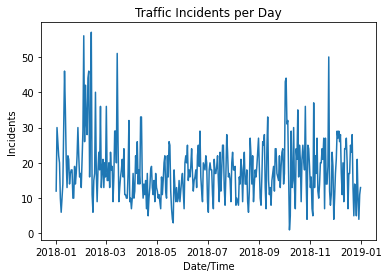

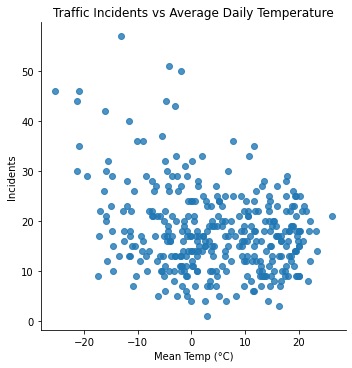

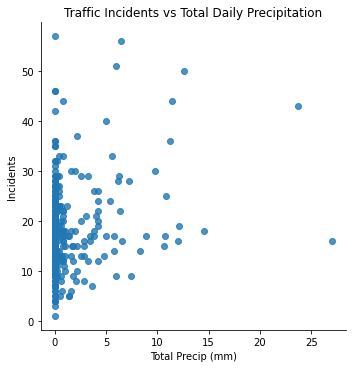

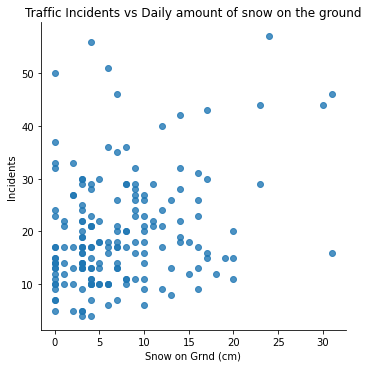

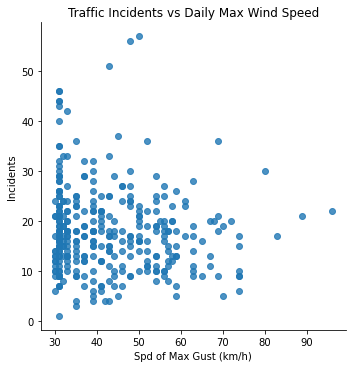

In [10]:
traffic_accidents_df = pd.read_csv("Traffic_Incidents.csv")

traffic_accidents_df.dropna(axis=1, how='all')    # remove the empty columns with all NaN values
traffic_accidents_df = traffic_accidents_df[~traffic_accidents_df.START_DT.str.contains("/2016 ")]     # remove all non 2018 data
traffic_accidents_df = traffic_accidents_df[~traffic_accidents_df.START_DT.str.contains("/2017 ")]
traffic_accidents_df = traffic_accidents_df[~traffic_accidents_df.START_DT.str.contains("/2019 ")]
traffic_accidents_df = traffic_accidents_df[~traffic_accidents_df.START_DT.str.contains("/2020 ")]
traffic_accidents_df = traffic_accidents_df.drop(['MODIFIED_DT','location','Count','id'],axis=1)
traffic_accidents_df = traffic_accidents_df.rename(columns={"QUADRANT": 'Incidents', 'START_DT' : 'Date/Time'})
traffic_accidents_df['Date/Time'] = pd.to_datetime(traffic_accidents_df['Date/Time'])
traf_acc_count_df = traffic_accidents_df.groupby(by=traffic_accidents_df['Date/Time'].dt.date).count().unstack()

temp = []
for name in traf_acc_count_df['INCIDENT INFO']:
    temp.append(name)
weather_df['Incidents'] = temp

sns.lineplot('Date/Time', 'Incidents', data=weather_df)
pl.title("Traffic Incidents per Day")

sns.lmplot('Mean Temp (°C)', 'Incidents', data=weather_df, fit_reg=False)
pl.title("Traffic Incidents vs Average Daily Temperature")

sns.lmplot('Total Precip (mm)', 'Incidents', data=weather_df, fit_reg=False)
pl.title("Traffic Incidents vs Total Daily Precipitation")

sns.lmplot('Snow on Grnd (cm)', 'Incidents', data=weather_df, fit_reg=False)
pl.title("Traffic Incidents vs Daily amount of snow on the ground")

sns.lmplot('Spd of Max Gust (km/h)', 'Incidents', data=weather_df, fit_reg=False)
pl.title("Traffic Incidents vs Daily Max Wind Speed")

## Read in the hourly weather data for each 2018 month (visibility data is only in the monthly datasets), clean and organize the data, and visualize

Text(0.5, 1.0, 'Traffic Incidents vs Daily Visibility')

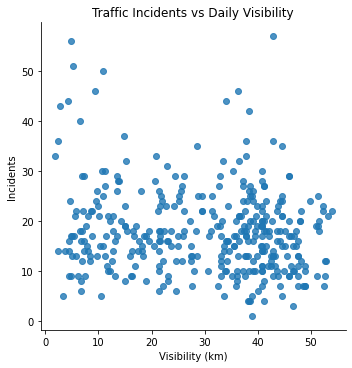

In [5]:
jan_data = pd.read_csv("2018_Jan_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
feb_data = pd.read_csv("2018_Feb_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
mar_data = pd.read_csv("2018_Mar_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
apr_data = pd.read_csv("2018_Apr_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
may_data = pd.read_csv("2018_May_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
jun_data = pd.read_csv("2018_Jun_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
jul_data = pd.read_csv("2018_Jul_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
aug_data = pd.read_csv("2018_Aug_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
sep_data = pd.read_csv("2018_Sep_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
oct_data = pd.read_csv("2018_Oct_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
nov_data = pd.read_csv("2018_Nov_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)
dec_data = pd.read_csv("2018_Dec_Hourly_Weather.csv", index_col='Date/Time', parse_dates=True)

all_df_list = [jan_data, feb_data, mar_data, apr_data, may_data, jun_data, jul_data, aug_data, sep_data, oct_data, nov_data, dec_data]

# Merge all the dataframes in all_df_list
# Pandas will automatically append based on similar column names
appended_df = pd.concat(all_df_list)
appended_df = appended_df.resample('D').mean()
appended_df = appended_df['Visibility (km)']

temp1 = []
for name in appended_df:
    temp1.append(name)
weather_df['Visibility (km)'] = temp1

sns.lmplot('Visibility (km)', 'Incidents', data=weather_df, fit_reg=False)
pl.title("Traffic Incidents vs Daily Visibility")